In [4]:
from preprocessed_mnist import load_dataset
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

Data preprocessing

In [23]:
X_train_flat = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test_flat = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
y_train = y_train.astype('int32')

In [24]:
total_train_ex = X_train_flat.shape[0]
num_features = X_train_flat.shape[1]
num_classes = 10

Defining Deep Neural Network Model:

2 hidden layers with 128 and 64 neurons respectively, Activation: ReLU

Dropout implemented

Weights initialized using Xavier Initializer

In [25]:
def model_NN(X, y, keep_prob):
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    num_neurons_hl1 = 128
    hidden_layer_1 = {'w':tf.Variable(initializer((num_features,num_neurons_hl1))), 
                      'b':tf.Variable(initializer((num_neurons_hl1,)))}
    
    num_neurons_hl2 = 64
    hidden_layer_2 = {'w':tf.Variable(initializer((num_neurons_hl1,num_neurons_hl2))), 
                      'b':tf.Variable(initializer((num_neurons_hl2,)))}
    
    output_layer = {'w':tf.Variable(initializer((num_neurons_hl2,num_classes))), 
                      'b':tf.Variable(initializer((num_classes,)))}
    
    l1 = tf.add(tf.matmul(X,hidden_layer_1['w']), hidden_layer_1['b'])
    l1 = tf.nn.relu(l1)
    l1_dropout = tf.nn.dropout(l1, keep_prob)
    
    l2 = tf.add(tf.matmul(l1_dropout,hidden_layer_2['w']), hidden_layer_2['b'])
    l2 = tf.nn.relu(l2)
    l2_dropout = tf.nn.dropout(l2, keep_prob)
    
    output = tf.matmul(l2_dropout,output_layer['w']) + output_layer['b']
    
    return output

In [26]:
X = tf.placeholder("float32",[None,num_features])
y = tf.placeholder("int32")
y_onehot = tf.one_hot(y, num_classes, axis=-1)
keep_prob = tf.placeholder(tf.float32)

In [27]:
predicted_y = model_NN(X, y, keep_prob)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y, labels=y_onehot) )

optimizer = tf.train.AdamOptimizer().minimize(loss)

In [28]:
epochs = 75 #maximum epochs, actually terminates earlier
batch_size = 500
batches_per_epoch = int(total_train_ex/batch_size)
dropout_keep_prob = 0.7

In [29]:
with tf.Session() as s:

    s.run(tf.global_variables_initializer())
    
    acc_tr=[]
    acc_test=[]
    
    loss_tr=[]
    loss_test=[]
    for epoch in range(epochs):
        
        #Training
        avg_loss = 0.0
        print("Epoch:", '%02d' % (epoch+1))
        for i in range(batches_per_epoch):
            batch_indices = np.random.randint(0, total_train_ex, size=(batch_size))
            batch_x = np.array([X_train_flat[i] for i in batch_indices])
            batch_y = np.array([y_train[i] for i in batch_indices])
            _, l = s.run([optimizer, loss], feed_dict={X: batch_x, y: batch_y, keep_prob: dropout_keep_prob})
            avg_loss += l /batches_per_epoch
        
        #Evaluation
        correct_prediction = tf.equal(tf.argmax(predicted_y, 1), tf.argmax(y_onehot, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        test_loss, test_acc = s.run([loss,accuracy], feed_dict={X: X_test_flat, y: y_test, keep_prob: 1.0})
        loss_test.append(test_loss)
        loss_tr.append(avg_loss)
        print("Training Loss =", "{:.9f}".format(avg_loss)) 
        print("Test Loss =", "{:.9f}".format(test_loss)) 
        
        acc_tr.append(accuracy.eval({X: X_train_flat, y: y_train, keep_prob:1.0}))
        acc_test.append(test_acc)
        print("Train Accuracy:", acc_tr[epoch])
        print("Test Accuracy:", acc_test[epoch])
        print("")
        
        if acc_tr[epoch]>0.98 and acc_test[epoch]>0.98:
            print("Goal accuracy reached, training stopped!")
            break

Epoch: 01
Training Loss = 0.932729730
Test Loss = 0.291409880
Train Accuracy: 0.91102
Test Accuracy: 0.9152

Epoch: 02
Training Loss = 0.369898205
Test Loss = 0.202645138
Train Accuracy: 0.93832
Test Accuracy: 0.9393

Epoch: 03
Training Loss = 0.283165951
Test Loss = 0.160810351
Train Accuracy: 0.95212
Test Accuracy: 0.9497

Epoch: 04
Training Loss = 0.229581169
Test Loss = 0.140288010
Train Accuracy: 0.9597
Test Accuracy: 0.9567

Epoch: 05
Training Loss = 0.201186776
Test Loss = 0.128122628
Train Accuracy: 0.96668
Test Accuracy: 0.96

Epoch: 06
Training Loss = 0.178740773
Test Loss = 0.118125461
Train Accuracy: 0.96936
Test Accuracy: 0.9633

Epoch: 07
Training Loss = 0.164439639
Test Loss = 0.110036731
Train Accuracy: 0.9732
Test Accuracy: 0.967

Epoch: 08
Training Loss = 0.149158298
Test Loss = 0.106523730
Train Accuracy: 0.97614
Test Accuracy: 0.9675

Epoch: 09
Training Loss = 0.144075713
Test Loss = 0.102446884
Train Accuracy: 0.9772
Test Accuracy: 0.9687

Epoch: 10
Training Loss =

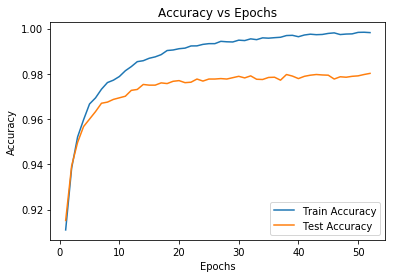

In [30]:
total_epochs = epoch+1
epochs_x = range(1,total_epochs+1)
plt.plot(epochs_x, acc_tr, epochs_x, acc_test)
plt.legend(['Train Accuracy','Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

Final Accuracies for all test set above 98% achieved! (Usually takes 40-50 epochs)

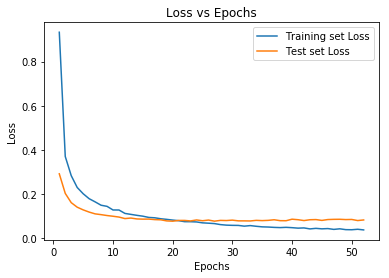

In [31]:
total_epochs = epoch+1
epochs_x = range(1,total_epochs+1)
plt.plot(epochs_x, loss_tr, epochs_x, loss_test)
plt.legend(['Training set Loss','Test set Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()